# 👩‍🚀 Deep Understanding of SVD with Visuals

What do Image Compression, Linear Regression, and PCA have in common? 

They all rely on one powerful mathematical tool: the **Singular Value Decomposition (SVD)**.

In this notebook, we’ll build an intuitive understanding of SVD using clear visuals, hands-on code, and practical applications. Whether you're compressing images, solving least squares problems, or reducing dimensionality with PCA, SVD is silently working under the engine. We'll explore its theoretical foundations, uncover its geometric meaning, and see it in action across multiple domains.

🎯 Goal: demystify SVD by breaking it down step by step and see its applications.


### Summary:
- 1. Definition of Singuar Values Decomposition
   - 1.1 Theorem
   - 1.2 Geometric Interpretation
   - 1.3 Algorithm
- 2. Linear Regression
    - 2.1 Theory
    - 2.2 Example with two parameters
    - 2.3 Time complexity
- 3. SVD applied to compression
   - 3.1 Reconstruction error
   - 3.2 Image compression
   - 3.3 Function approximation
- 4. PCA
   - 4.1 Algorithm
   - 4.2 Visual interpretation
   - 4.3 Clustering

In [2]:
import math
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import timeit

from sklearn.preprocessing import add_dummy_feature
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# Reproducibility
np.random.seed(15)

## 1. Definition of Singuar Values Decomposition

### 1.1 Theorem

**Singular Value Decomposition Theorem:** Let $A$ be a real (or complex) $m \times n$ matrix. The Singular Value Decomposition (SVD) of $A$ is a factorization of the form:
$$
\mathbf{A} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T \qquad \text{with} \qquad {\mathbf{\Sigma}} = \begin{bmatrix}
    \sigma_1 & 0 & \cdots & 0   \\
    0 & \sigma_2 & \ddots & \vdots \\
    \vdots & \ddots & \ddots & 0 \\
    \vdots & & \ddots &  \sigma_m\\
    \vdots &  &  &  0 \\
    0 & \cdots & \cdots & 0
\end{bmatrix} \in \mathbb{R}^{m \times n}
$$

where:
- $U \in \mathbb{R}^{m \times m}$ is an orthogonal matrix, i.e., $U^T U = I_m$. Its columns are the left singular vectors of $A$.
- $V \in \mathbb{R}^{n \times n}$ is an orthogonal matrix, i.e., $V^T V = I_n$. Its columns are the right singular vectors of $A$.
- $\Sigma \in \mathbb{R}^{m \times n}$ is a diagonal matrix with the *singular values* $\sigma_i$ on the diagonal.

The matrix $\Sigma$ has been represented in the case $n > m$. The $\sigma_i$ are called the singular values of $\mathbf{A}$. They are the square roots of the eigenvalues of the matrix ${\mathbf{A}}^T{\mathbf{A}}$. They are necessarily *real, positive, or zero*; they can be arranged in any order, but for a given order, the decomposition is unique. From now on, we choose descending order: $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_r > 0$ (where $r = \operatorname{rank}(A)$)

The result can also be written as:  
$${\mathbf{A}} = {\mathbf{U}}{\mathbf{\Sigma}}{\mathbf{V}}^T = \sum_{i=1}^r \sigma_i {\mathbf{u}}_i {\mathbf{v}}_i^T$$  
which expresses the matrix as the sum of $\operatorname{rank}({\mathbf{A}})$ matrices of rank-1 contributions. Vectors ${\mathbf{u}}_i$ and ${\mathbf{v}}$ are the columns of matrices $U$ and $V$. The vector product ${\mathbf{u}}_i {\mathbf{v}}_i^T$ (outer product) returns a matrice.  

This theorem generalize the diagonalization (and inversion which we'll see later on) to rectangular matrices, which was only defined for square matrices.


### 1.2 Geometric Interpretation

The SVD provides a geometric interpretation of the action of matrix on a set of points. Matris $A$ maps the unit sphere in $\mathbb{R}^n$ to an ellipsoid in $\mathbb{R}^m$. The SVD allows us to compute the axis of the ellipsoid, which are oriented along the left singular vectors and are scaled by the singular values of $A$.

In [ ]:
# Step 1: Generate unit circle in R^2
theta = np.linspace(0, 2 * np.pi, 200)
circle = np.stack([np.cos(theta), np.sin(theta)])  # shape (2, 200)

# Step 2: Define a 2x2 matrix A
A = np.array([[3, 1], [1, 2]])

# Step 3: Compute SVD of A
U, S, Vt = np.linalg.svd(A)

# Step 4: Apply transformation A to the unit circle
ellipse = A @ circle

# Step 5: Axes of the ellipse are columns of U scaled by singular values
ellipse_axes = [S[i] * U[:, i] for i in range(2)]


# Plot
plt.figure(figsize=(8, 8))
plt.plot(circle[0], circle[1], label="Original Circle", linestyle="--")
plt.plot(ellipse[0], ellipse[1], label="Transformed Circle", linewidth=2)

# Plot singular vector directions
origin = np.zeros(2)
for i, vec in enumerate(ellipse_axes):
    plt.quiver(*origin, *vec, angles='xy', scale_units='xy', scale=1, color=f"C{i+2}", width=0.007, label=f"$\sigma_{i+1} u_{i+1}$")

plt.gca().set_aspect('equal')
plt.title("Unit Circle Mapped to Ellipse via A")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()

### 1.3 Algorithm

We will now code the SVD in the case of a real square matrix. We therefore write ${\mathbf{A}} = {\mathbf{U}}{\mathbf{\Sigma}}{\mathbf{V}}^T$. The computation of the SVD consists in finding the eigenvalues and eigenvectors of $\mathbf{A}\mathbf{A}^T$ and $\mathbf{A}^T\mathbf{A}$. The eigenvectors of $\mathbf{A}^T\mathbf{A}$ form the columns of $\mathbf{V}$, while the eigenvectors of $\mathbf{A}\mathbf{A}^T$ form the columns of $\mathbf{U}$. As stated earlier, the singular values in $\mathbf{\Sigma}$ are the square roots of the eigenvalues of either $\mathbf{A}\mathbf{A}^T$ or $\mathbf{A}^T\mathbf{A}$.

The singular values are the diagonal entries of the matrix $\mathbf{\Sigma}$ and are sorted in decreasing order, and the eigenvectors in U and V matrices are reordered accordingly. If $v$ is an eigenvector, then $-v$ is also an eigenvector, and different decompositions can lead to different eigenvectors signs, so we will verify the following equation to ensure that the signs are the same:
$${\mathbf{A}}\mathbf{V} = \mathbf{U}\mathbf{\Sigma}$$

In [ ]:
n = 6
A = np.random.random((n, n))

def svd(A):
    S, U = la.eigh(A.dot(A.T))
    S, V = la.eigh(A.T.dot(A))
    S = np.sqrt(S)
    idx = S.argsort()[::-1]
    S = S[idx]
    U = U[:,idx]
    V = V[:,idx]
    # matrix of 1's and -1's to satisfy the equality AV = US
    MS = 2 * np.isclose(A.dot(V), (U.dot(np.diag(S)))) - 1
    V = MS * V
    return U, S, V.T


# custom function call
U, S, V = svd(A)
S = np.diag(S) # vector to matrix

# SVD using numpy's built-in function
Unp, Snp, Vnp = la.svd(A)
Snp = np.diag(Snp)

# Matrices coefs equality check
print(np.allclose(A, U @ S @ V))
print(np.allclose(A, Unp @ Snp @ Vnp))

True
True


## 2. Linear Regression

### 2.1 Theory

Linear regression aims to find the parameter vector $ \Theta \in \mathbb{R}^d $ that best fits a set of observations $ (X, y) $, where $X \in \mathbb{R}^{n \times d} $ is the design matrix and $ y \in \mathbb{R}^n $ is the vector of target values. The model assumes a linear relationship given by the matrix equation:
$$
X \Theta = y.
$$
When $ X $ does not have full column rank or when the system is overdetermined (i.e., $ n > d $), the equation may not have an exact solution. In such cases, we seek the least-squares solution that minimizes the squared error $ \| X \Theta - y \|_2^2 $. The analytical solution is given by:
$$
\Theta = X^{+} y,
$$
where $ X^{+} $ denotes the Moore–Penrose pseudoinverse of $ X $. To compute $ X^{+} $, we can use the singular value decomposition (SVD). Let $ X = U \Sigma V^\top $ be the SVD of $ X $, then the pseudoinverse is given by $X^{+} = V \Sigma^{+} U^\top$, where $ \Sigma^{+} $ is formed by taking the inverse of each non-zero singular value in $ \Sigma $ (in practice, each singular value superior to a small threshold) and padding with zeros if the singular values are inferior to the threshold. This approach ensures a stable and general solution, even when $ X $ is not of full rank.

Note: The solution can also be given by the normal equation, but is less stable and more costly to compute due to the matrix inversion: $ \Theta = (X^{T}X)^{-1}X^{T} y $

### 2.2 Example with two parameters

In simple linear regression with two parameters, we aim to model the relationship between a scalar input $x$ and a target variable $y$ as a linear function:
$$
y = \theta_0 + \theta_1 x,
$$
where $\theta_0$ is the intercept and $\theta_1$ is the slope. Given a dataset of $n$ observations $(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)$, we can write the model in matrix form as:
$$
X \Theta = y,
$$
with:
$$
X = \begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_n \\
\end{bmatrix}, \quad
\Theta = \begin{bmatrix}
\theta_0 \\
\theta_1 \\
\end{bmatrix}, \quad
y = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n \\
\end{bmatrix}.
$$

To find the best linear fit in the least-squares sense, we seek the parameter vector $\Theta$ given by:
$$
\Theta = X^+ y \qquad with \qquad X^+ = V \Sigma^+ U^\top
$$

This leads to a stable and general method for solving the linear regression problem, even when $X$ is not of full rank. For this simple 2-parameter regression, the formulas can be derived analytically:

$$
\theta_1 = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}   
$$
$$
\theta_0 = \bar{y} - \theta_1 \bar{x}
$$

where $\bar{x}$ and $\bar{y}$ represent the mean values of those vectors.

In [ ]:
# Inputs X
nb_points = 100
X = 2 * np.random.rand(nb_points, 1)
X_b = add_dummy_feature(X) # add a column of 1s

# Outputs y
bias = 4
slope = 3
y = bias + slope * X + np.random.rand(nb_points, 1) # add noise



# SVD
U, S, V = la.svd(X_b)
St = np.diag([1/s if s > 1e-5 else 0 for s in S]) # inverse singular values
St = np.hstack([St, np.zeros((2, nb_points-2))]) # transform a (2*2) matrix to a (100*2) matrix
theta_svd = V.T @ St @ U.T @ y

# PSEUDO INVERSE
theta_la = np.linalg.pinv(X_b) @ y

# NORMAL EQUATION
theta_normal = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

# LINEAR REGRESSION
model = LinearRegression()
model.fit(X, y.ravel())
theta_lr = np.array([[model.intercept_], model.coef_])

# ANALYTICAL FORMULAS
x_mean = np.mean(X)
y_mean = np.mean(y)
theta_1 = np.sum((X - x_mean) * (y - y_mean)) / np.sum((X - x_mean) ** 2)
theta_0 = y_mean - theta_1 * x_mean
theta_formula = [[theta_0], [theta_1]]



# CONFIRMATION
print(np.allclose(theta_svd, theta_la))
print(np.allclose(theta_svd, theta_lr))
print(np.allclose(theta_svd, theta_normal))
print(np.allclose(theta_svd, theta_formula))



x_line = np.array([[0], [2]]) # form a line from 2 points
y_line = add_dummy_feature(x_line) @ theta_svd # 1 * theta0 + x * theta1


# Plot graph
plt.plot(X, y, "b.", label="data points") 
plt.plot(x_line, y_line, "red", label="fitted line")
plt.xlabel("Input x")
plt.ylabel("Output y")
plt.title("Regression line computed with SVD")
plt.legend()
plt.show()

### 2.3 Time complexity

Let's see which algorithm is faster!

In [ ]:
n_points = 100 
n_features = 10 
X = 2 * np.random.rand(n_points, n_features)
y = 4 + 3 * X + np.random.rand(n_points, n_features)

model = LinearRegression()

def svd(X, y):
    X_b = add_dummy_feature(X)
    U, S, V = la.svd(X_b)
    St = np.diag([1/s if s > 1e-5 else 0 for s in S])
    St = np.hstack([St, np.zeros((n_features+1, n_points-n_features-1))])
    theta_svd = V @ St @ U.T @ y
    return theta_svd

def pinverse(X, y):
    X_b = add_dummy_feature(X)
    theta_la = np.linalg.pinv(X_b) @ y
    return theta_la

def normal(X, y):
    X_b = add_dummy_feature(X)
    theta_normal = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
    return theta_normal

def lr(X, y):
    model.fit(X, y)
    theta_lr = np.vstack((model.intercept_, model.coef_))
    return theta_lr


exe_time_svd = np.array(timeit.repeat('svd(X, y)', globals=globals(), number=100)) / 1e2
exe_time_pin = np.array(timeit.repeat('pinverse(X, y)', globals=globals(), number=100)) / 1e2
exe_time_nor = np.array(timeit.repeat('normal(X, y)', globals=globals(), number=100)) / 1e2
exe_time_lin = np.array(timeit.repeat('lr(X, y)', globals=globals(), number=100)) / 1e2

strings = ['lin reg  ', 'svd      ', 'pinverse ', 'normal   ']
times = [exe_time_lin, exe_time_svd, exe_time_pin, exe_time_nor]

for str, tim in zip(strings, times):
    print(f"Execution time {str}: {(np.mean(tim)/1e-3):.3f} ms, variance : {(np.var(tim)/1e-9):.2f} ns")

Execution time lin reg  : 0.633 ms, variance : 3.77 ns
Execution time svd      : 0.380 ms, variance : 9.76 ns
Execution time pinverse : 0.233 ms, variance : 0.64 ns
Execution time normal   : 0.162 ms, variance : 0.03 ns


Note: even if the normal equation gives faster time execution, this algorithm is not commonly used as it is unstable, especially if the matrix is poorly conditionned or singular.

## 3. SVD applied to image compression

### 3.1 Approximation error

How well can we approximate a matrix $\mathbf{A}$ with rank-1 matrix? Mathematics tells us that ${\mathbf{A}}_k$ is the best rank-$k$ approximation of ${\mathbf{A}}$ in the sense of the Euclidean norm, and the singular value $\sigma_{k+1}$ represents the lower bound of the approximation error:
$$
\min_{{\operatorname{rg}({\mathbf{B}})}=k}\|{\mathbf{A}}-{\mathbf{B}}\|_2 = \|{\mathbf{A}}-{\mathbf{A}}_k\|_2 = \sigma_{k+1}
$$
$$
\text{ where } {\mathbf{A}}_k = \sum_{i=1}^k{\mathbf{A}}_i = \sum_{i=1}^k\sigma_i{\mathbf{u}}_i {\mathbf{v}}_i^T
$$

Let's see how the number of singular values kept ($k$) affects the reconstruction error of the matrix $\mathbf{A}_k$.

In [ ]:
n = 20
index = np.arange(1, n+1)
A = np.random.random((n, n))
U, S, V = la.svd(A)

plt.figure(figsize=(10,3))
plt.title("Singular value $\sigma_k$")
plt.bar(index, S)
plt.xticks(index)
plt.show()


# Ak matrix contruction 
norms = []
for i in range(n):
    Ak = U[:, :i] @ np.diag(S[:i]) @ V[:i, :]
    norms.append(la.norm((A - Ak), 2))

plt.figure(figsize=(10,3))
plt.title("${||{\mathbf{A}}-{\mathbf{A}_k}||}_2$")
plt.bar(index, norms)
plt.xticks(index)
plt.show()



### 3.2 Image compression 

This equality also allows us to compress information contained in a matrix with a minimumized lost information. Let's see the visual impact of this decomposition on a 512*512 black and white image (each pixel is stocked in a matrix with a value encoded on 256 grey levels). We are going to reconstruct this image with 1, 5, 10, 15, 20, 50, 100, 200 singular values and observe how it affect it. But first, let's see what a single feature ${\mathbf{A}}_i$ looks like, defined by:
$$
{\mathbf{A}}_i=\sigma_i{\mathbf{u}}_i {\mathbf{v}}_i^T
$$

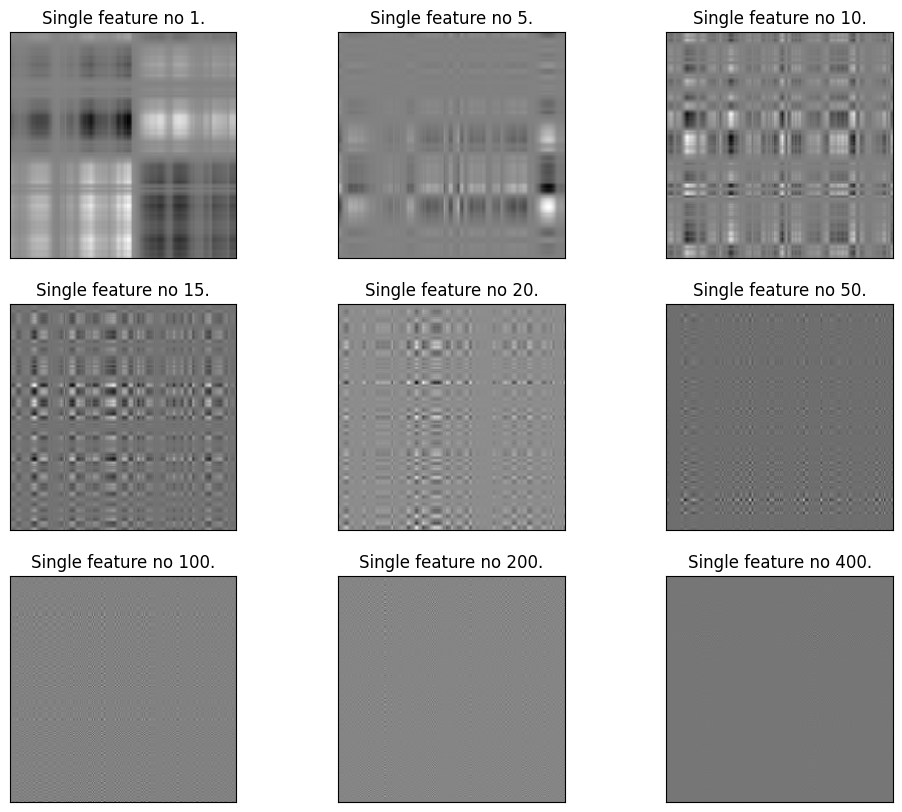

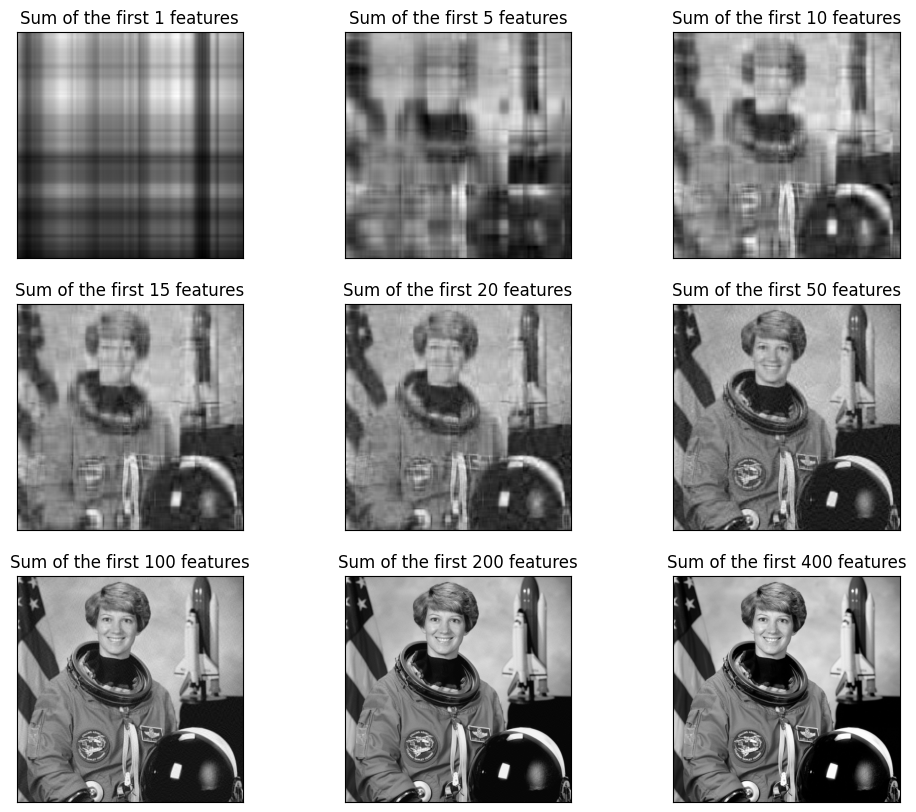

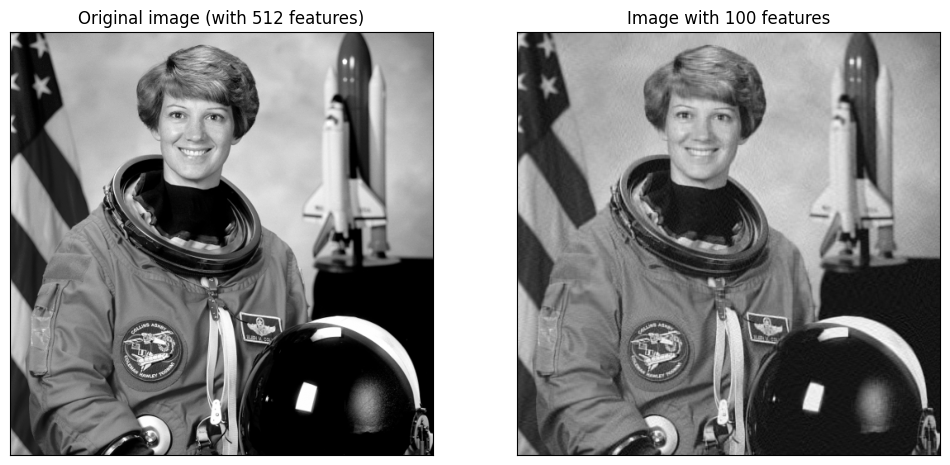

In [ ]:
from skimage import data
from skimage.color import rgb2gray


image = data.astronaut()
image = np.asarray(rgb2gray(image))


# SVD
U,S,V = la.svd(image)

# Singular values number
comps = [1, 5, 10, 15, 20, 50, 100, 200, 400]

plt.figure(figsize=(12, 10))
for i in range(len(comps)):
    Ai = S[comps[i]] * np.outer(U[:, comps[i]], V[comps[i], :])
    plt.subplot(3, 3, i+1)
    plt.imshow(Ai, cmap='gray')
    plt.title(f'Single feature no {comps[i]}.')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_ticks([])
    frame1.axes.get_yaxis().set_ticks([])
    

plt.figure(figsize=(12, 10))
for i in range(len(comps)):
    Ak = U[:, :comps[i]] @ np.diag(S[:comps[i]]) @ V[:comps[i], :]
    plt.subplot(3, 3, i+1)
    plt.imshow(Ak, cmap='gray')
    plt.title(f"Sum of the first {comps[i]} features")
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_ticks([])
    frame1.axes.get_yaxis().set_ticks([])



plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original image (with 512 features)')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])

plt.subplot(1, 2, 2)
n = 200
Ak = U[:, :n] @ np.diag(S[:n]) @ V[:n, :]
plt.imshow(Ak, cmap='gray')
plt.title(f'Image with {n} features')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.show()




The error of the reconstructed matrices decrease exponentially with the number of singular values used (it follows the previous histogram of $\|{\mathbf{A}}-{\mathbf{A}_k}\|_2$ in Part 3.1).

### 3.3 Function approximation

In the same way, we can reconstruct functions with few SVD features. Regular functions are smooth, so very few features will be necessary. This compression can be usefull when stocking functions with many data points or high dimensionnal.

In [ ]:

def bird(x,y):
    return np.sin(x)*(np.exp(1-np.cos(y))**2) + np.cos(y)*(np.exp(1-np.sin(x))**2) + (x-y)**2

x = np.linspace(-2*math.pi, 2*math.pi,100)
y = np.linspace(-2*math.pi, 2*math.pi,100)
X, Y = np.meshgrid(x,y)
Z = bird(X,Y)
birdarray = np.asarray(Z)

# SVD
U,S,V = la.svd(birdarray)


# Singular values number
comps = [1, 2, 3, 4, 5, 10, 20, 30, 50]

fig=plt.figure(figsize=(12, 10))
for i in range(len(comps)):
    bird_rank = S[comps[i]] * np.outer(U[:, comps[i]], V[comps[i], :])
    ax=fig.add_subplot(330+i+1,projection='3d')
    ax.plot_surface(X,Y,bird_rank,cmap='coolwarm')
    plt.title(f'Single feature no {comps[i]}')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_ticks([])
    frame1.axes.get_yaxis().set_ticks([])

fig=plt.figure(figsize=(12, 10))
for i in range(len(comps)):
    bird_rank = U[:, :comps[i]] @ np.diag(S[:comps[i]]) @ V[:comps[i], :]
    ax=fig.add_subplot(330+i+1,projection='3d')
    ax.plot_surface(X,Y,bird_rank,cmap='coolwarm')
    plt.title(f'Sum of the first {comps[i]} features')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_ticks([])
    frame1.axes.get_yaxis().set_ticks([])

fig=plt.figure(figsize=(12, 6))
ax=fig.add_subplot(121,projection='3d')
ax.plot_surface(X,Y,Z,cmap='coolwarm')
plt.title('Original function (100 features)')
ax=fig.add_subplot(122,projection='3d')
bird_rank = U[:, :5] @ np.diag(S[:5]) @ V[:5, :]
ax.plot_surface(X,Y,bird_rank,cmap='coolwarm')
plt.title('Fonction with 5 features')
plt.show()

## 4. PCA

Principal components analysis is the main method used for dimension reduction.
It performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. The variance of a dataset projected on an eigenvector is proportionnal to the eigenvalue of this eigenvector, so if we select the eigenvectors with higher eigenvalues, we can construct the hyperplane where the projected dataset will have the maximum variance. With maximum variance, maximum information is preserved during the projection. 
$$
\boxed{variance \propto eigenvalues}
$$


### 4.1 PCA Implementations

Let $ X \in \mathbb{R}^{n \times d} $ be a data matrix with $ n = 100 $ samples and $ d = 10 $ features. The goal of Principal Component Analysis (PCA) is to reduce the dimensionality of $ X $ by projecting it onto a new set of orthogonal axes (principal components) that capture the maximum variance in the data.

We begin by centering the data:

$$
X_{\text{c}} = X - \mu, \quad \text{where } \mu = \frac{1}{n} \sum_{i=1}^n X_i
$$

#### 1. PCA via Covariance Matrix (Eigen-Decomposition)

The eigenvectors and eigenvalues of a covariance (or correlation) matrix are the core of PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix, which is a matrix where each element represents the covariance between two features. The covariance between two features is calculated as follows:
$$
Cov(X, Y) = \frac{\sum(x_i - \bar{x}) (y_i - \bar{y})}{N-1}
$$

To compute the complete covariance matrix, we use the following formula:

$$
M_{cov} = \frac{1}{n-1} X_{\text{c}}^\top X_{\text{c}} \in \mathbb{R}^{d \times d}
$$

We then perform an eigen-decomposition of $ M_{cov} $:

$$
M_{cov} = V \Lambda V^\top
$$

Here:
- $ V \in \mathbb{R}^{d \times d} $ contains the eigenvectors,
- $ \Lambda \in \mathbb{R}^{d \times d} $ is a diagonal matrix of eigenvalues.

We sort the eigenvalues in descending order and select the top $ k = 2 $ associated eigenvectors $ V_k \in \mathbb{R}^{d \times k} $. The data is projected onto these components:

$$
\boxed{X_{\text{PCA}} = X_{\text{c}} \cdot V_k}
$$

#### 2. PCA via Singular Value Decomposition (SVD)

Instead of computing the covariance matrix, we can directly apply the Singular Value Decomposition (SVD) to the data:

$$
X_{\text{c}} = U \Sigma V^\top
$$

As the matrices $U$ and $V$ are orthogonal ($U\cdot U^T = Id$), it can be shown that:

$$
X_{\text{c}}^\top X_{\text{c}} = V \Sigma^2 V^\top
$$

So the right singular vectors $ V $ are the same as the eigenvectors of the covariance matrix, and the singular values squared are proportional to the eigenvalues: $\lambda_i = \frac{\sigma_i^2}{n-1}$. The Principal Components are the eigenvectors of $X$, given by the columns of $ V $. To project the data onto the first $ k $ principal components (here, $ k = 2 $), we compute:
$$
\boxed{X_{\text{PCA}} = X_{\text{c}} \cdot V_k}
$$

Advantage: This approach avoids explicitly computing the covariance matrix, making it more stable and computationally efficient, especially for large or high-dimensional data.


#### 3. PCA via Scikit-learn

The scikit-learn implementation automates the steps above. Internally, it also uses SVD for performance:

- It centers the data automatically.
- It computes the top $ k $ components using a truncated SVD.

Since PCA components are defined up to a sign (if $v$ is an eigenvector, then $-v$ is also an eigenvector), the projections might differ by their sign but are otherwise equivalent. We will check the equality between the absolute values of the projections. The results are numerically equivalent, confirming the theoretical result: the eigen-decomposition of the covariance matrix is equivalent to the SVD of the centered data.  

In the next code cell, we illustrate how to perform Principal Component Analysis (PCA) using the manual Eigenvectors decomposition and the Singular Value Decomposition, and compare the results with the PCA implementation provided by scikit-learn.

In [ ]:
# Data X of dimension (n_samples, n_features)
X = np.random.normal(size=(100, 10))
Xc = X - np.mean(X, axis=0)


## 1. PCA with covariance matrix
# Correlation matrix
cov_matrix = np.cov(Xc.T)
# Decomposition
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
# Order with decreasing eigenvalues 
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
# Projection (n_features, 2)
X_pca_cov = Xc @ eigenvectors[:, :2]


## 2. PCA with SVD
U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
# Selection of the 2 first eigenvectors (principal components) contained in V 
Vk = Vt[:2].T  # Projection matrix (features x 2)
X_pca_svd = Xc @ Vk


## 3. PCA with scikit-learn
pca = PCA(n_components=2)
X_pca_sklearn = pca.fit_transform(X) # centers data by default



# Results comparison
# PCA decomposition are unique modulo their sign, so we compare absolute values
print(np.allclose(np.abs(X_pca_sklearn), np.abs(X_pca_cov)))
print(np.allclose(np.abs(X_pca_sklearn), np.abs(X_pca_svd)))

True
True
(100, 2)


### 4.2 Visual Interpretation

In the next cell, we construct a synthetic 2D dataset to illustrate the principles and geometric intuition behind PCA. We begin by generating normally distributed points and stretching them along one axis to form an ellipsoidal shape, then apply a rotation to introduce correlation between the variables. PCA is then applied to this rotated dataset to identify the directions of maximum variance (its principal components). These components are visualized as red arrows overlaying the data, and we compare the original and transformed data through histograms of their projections onto both the original axes and the principal axes. This example shows how PCA decorrelates data and concentrates variance along orthogonal directions.

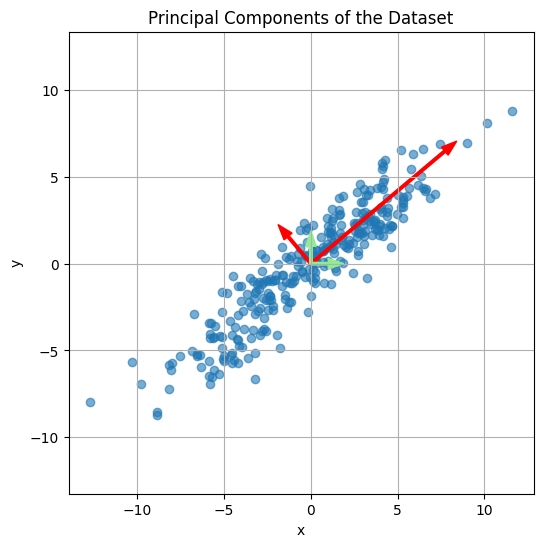

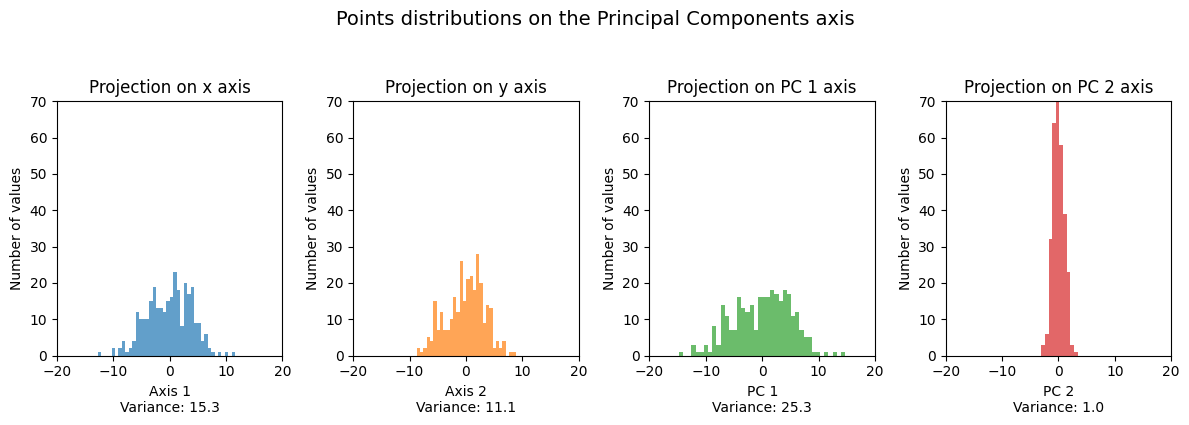

Explained variance ratio of PC1 and PC2: [0.96045461 0.03954539]


In [4]:
# Ellipsoidal 2D dataset
X = np.random.normal(size=(300, 2))
stretch_factors = np.array([5, 1])
X_stretched = X * stretch_factors

# Rotation 
theta = np.radians(-40)
R_x = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])
X_rotated = X_stretched @ R_x 



# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_rotated)
components = pca.components_                  # Eigenvectors
explained_variance = pca.explained_variance_  # Eigenvalues

# Plotting the results
plt.figure(figsize=(6, 6))
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], alpha=0.6)

for i, (length, vector) in enumerate(zip(explained_variance, components)):
    vector_scaled = np.sqrt(length) * vector * 2
    plt.arrow(0, 0, vector_scaled[0], vector_scaled[1], color='red', width=0.15, head_width=0.6)
    plt.arrow(0, 0, -i+1, i, color='lightgreen', width=0.15, head_width=0.6)
plt.title("Principal Components of the Dataset")
plt.axis('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


# Common scale limit
x_min, x_max = -20, 20
axis = ["x", "y"]

# Distributions plotting
fig = plt.figure(figsize=(12, 4))
for i in range(2): 
    plt.subplot(1, 4, i+1)
    plt.hist(X_rotated[:, i], bins=40-i*10, color=f"C{i}", alpha=0.7)
    plt.title(f"Projection on {axis[i]} axis")
    plt.xlabel(f"Axis {i+1}\nVariance: {np.var(X_rotated[:, i]):.1f}")
    plt.ylabel("Number of values")
    plt.xlim(x_min, x_max)
    plt.ylim(0, 70)
for i in range(2):
    plt.subplot(1, 4, i+3)
    plt.hist(X_pca[:, i], bins=40-i*30, color=f"C{i+2}", alpha=0.7)
    plt.title(f"Projection on PC {i+1} axis")
    plt.xlabel(f"PC {i+1}\nVariance: {np.var(X_pca[:, i]):.1f}")
    plt.ylabel("Number of values")
    plt.xlim(x_min, x_max)
    plt.ylim(0, 70)

plt.suptitle("Points distributions on the Principal Components axis", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


print(f"Explained variance ratio of PC1 and PC2: {pca.explained_variance_ratio_}")


### 4.3 Clustering 

Dimensionnality reduction algorithms allows us to visualize complex dataset. After a PCA, we can plot on the 2 first Principal Components the projected dataset and see the formed clusters. Let's try this on the simple iris dataset containing 4 features of different flowers.

In [ ]:
from sklearn.datasets import load_iris

data = load_iris()
X, y = data.data, data.target
flower_names = data.target_names

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


plt.figure(figsize=(8, 6))
for i, flower in enumerate(flower_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=flower)
plt.title("PCA on the Iris dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

We can test the PCA algorithm on a much more complex dataset: MNIST. It contains hand-written digits drawn on a 28*28 square in grayscale, so the dataset has 784 features (variables) per line.

In [ ]:
from sklearn.datasets import fetch_openml

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X, y = mnist.data[:3000], mnist.target[:3000]

pca = PCA(n_components=2, random_state=42)
X_pca_reduced = pca.fit_transform(X)

plt.figure(figsize=(12, 10))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y.astype(np.int8), cmap="jet", alpha=0.8)
plt.title("PCA on the MNIST dataset")
plt.axis('off')
plt.colorbar()
plt.show()


PCA is a linear projection method, it is not ideal for complex and non linear data. MNIST is composed of hand-written numbers, and their variations (style, orientation, pen used) doesn't match with a simple linear projection. That's why we obtain a blured cloud without well separated clusters. Moreover, the PCA algorithm tries to maximize the variance between variables, which doesn't lead to distinct clusters.  

Let's try another dimentionnality reduction algorithm specialized in clustering: t-SNE

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
X_reduced = tsne.fit_transform(X)

plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y.astype(np.int8), cmap="jet", alpha=0.8)
plt.title("T-SNE on the MNIST dataset")
plt.axis('off')
plt.colorbar()
plt.show()

Impressive! Most digits are nicely separated from the others, even though t-SNE wasn't given the targets: it just identified clusters of similar images. There is still a bit of overlap. For example, the 3s and the 5s overlap a lot (on the right side of the plot), and so do the 4s and the 9s (in the top-right corner). It makes sens as these digits are similar when hand-written.